<a name="top" id="top"></a>

<div align="center">
    <h1>CUDA-Q</h1>
    <a href="https://github.com/bernalde">David E. Bernal Neira</a>
    <br>
    <i>Davidson School of Chemical Engineering, Purdue University</i>
    <br>
    <br>
    <a href="https://github.com/sergey-gusev94">Sergey Gusev</a>
    <br>
    <i>Davidson School of Chemical Engineering, Purdue University</i>
    <br>
    <br>
    <a href="https://colab.research.google.com/github/sergey-gusev94/QUBONotebooks/blob/main/notebooks_py/7-CUDA-Q_python.ipynb" target="_parent">
        <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
    </a>
    <a href="https://secquoia.github.io/">
        <img src="https://img.shields.io/badge/🌲⚛️🌐-SECQUOIA-blue" alt="SECQUOIA"/>
    </a>
</div>

# Solving Linear Constrained Binary Optimization with QAOA and CUDA-Q

This notebook demonstrates how to solve **linear constrained binary optimization problems** using the **Quantum Approximate Optimization Algorithm (QAOA)** implemented with NVIDIA's **CUDA-Q** package.

## Overview

QAOA is a hybrid quantum-classical algorithm designed for combinatorial optimization problems. In this tutorial, we apply QAOA to solve a specific type of problem:

**Linear Constrained Binary Optimization Problem:**
- **Objective**: Minimize a linear function of binary variables
- **Constraints**: Linear equality constraints 
- **Variables**: Binary variables x ∈ {0,1}ⁿ

## Methodology

Our approach follows these key steps:
1. **QUBO Conversion**: Transform the constrained problem into an unconstrained QUBO (Quadratic Unconstrained Binary Optimization) by adding penalty terms for constraint violations
2. **Ising Mapping**: Convert the QUBO matrix to an Ising Hamiltonian suitable for quantum computation
3. **QAOA Implementation**: Use parameterized quantum circuits to find approximate solutions
4. **Classical Optimization**: Optimize circuit parameters using classical methods (L-BFGS-B)
5. **Solution Extraction**: Sample the optimized quantum state to obtain candidate solutions

The specific problem we solve has 11 binary variables with 3 linear equality constraints, demonstrating how QAOA can handle real-world optimization scenarios where feasibility must be maintained.


In [55]:
# If using this on Google Colab, we need to install the packages
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

# Let's install required packages
if IN_COLAB:
    import subprocess
    import sys
    
    packages = ['cudaq', 'dimod', 'scipy', 'networkx', 'matplotlib']
    for package in packages:
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', package])

In [56]:
# Optional: Configure CUDA-Q simulator settings
# If you encounter GPU-related issues, uncomment the following lines:
import os
import dotenv

# Create or ensure .env exists or set overrides directly:
dotenv.set_key(".env", "CUDAQ_DEFAULT_SIMULATOR", "qpp-cpu")
dotenv.set_key(".env", "CUDA_VISIBLE_DEVICES", "")

dotenv.load_dotenv(".env", override=True)
os.environ["CUDAQ_DEFAULT_SIMULATOR"] = "qpp-cpu"
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [57]:
# Additional package installations for enhanced functionality
# Install additional visualization and quantum tools if needed

import sys

try:
    import matplotlib.pyplot as plt
    # Optional quantum tools
    try:
        import qutip
        import ipywidgets as widgets
    except ImportError:
        print("Optional quantum tools (qutip, ipywidgets) not found.")
        print("These are not required for basic CUDA-Q functionality.")

except ImportError:
    print("Installing required visualization tools...")
    import subprocess
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'matplotlib>=3.5'])
    print("Matplotlib installed. Please restart your kernel if needed.")

In [58]:
# Import necessary packages for QAOA implementation

import networkx as nx
import cudaq
from cudaq import spin
from cudaq.qis import *
import numpy as np
import matplotlib.pyplot as plt
from typing import List
import itertools, math

# Optional: Import widgets for interactive elements
try:
    import ipywidgets as widgets
    from ipywidgets import interact
    HAS_WIDGETS = True
except ImportError:
    HAS_WIDGETS = False
    print("ipywidgets not available - interactive features disabled")

print("All required packages imported successfully!")


All required packages imported successfully!


## Problem Definition: Linear Constrained Binary Optimization

We will solve a linear constrained binary optimization problem that demonstrates the practical application of QAOA to real-world scenarios where both optimization and feasibility are important.

**Problem Type**: This is a classic operations research problem where we seek to minimize costs while satisfying resource or capacity constraints. Such problems arise in logistics, resource allocation, production planning, and many other domains.

### Example
Suppose we want to solve the following problem via QUBO
$$
\min_{\mathbf{x}} 2𝑥_0+4𝑥_1+4𝑥_2+4𝑥_3+4𝑥_4+4𝑥_5+5𝑥_6+4𝑥_7+5𝑥_8+6𝑥_9+5𝑥_{10} \\
s.t. \begin{bmatrix}
1 & 0 & 0 & 1 & 1 & 1 & 0 & 1 & 1 & 1 & 1\\
0 & 1 & 0 & 1 & 0 & 1 & 1 & 0 & 1 & 1 & 1\\
0 & 0 & 1 & 0 & 1 & 0 & 1 & 1 & 1 & 1 & 1
\end{bmatrix}\mathbf{x}=
\begin{bmatrix}
1\\
1\\
1
\end{bmatrix} \\
\mathbf{x} \in \{0,1 \}^{11}
$$


#### QUBO Formulation
We define a QUBO (Quadratic Unconstrained Binary Optimization) as the following optimization problem:
$$
\min_{x \in \{0,1 \}^n} \sum_{i=1}^n Q_{ii}x_i + \sum_{i<j} Q_{ij}x_i x_j + c_Q = \min_{x \in \{0,1 \}^n}  x^\top Q x + c_Q
$$
where we optimize over binary variables $x \in \{ 0,1 \}^n$, with $Q$ being the QUBO matrix containing both linear coefficients (diagonal terms) and quadratic interaction terms (off-diagonal terms). The constant offset $c_Q$ does not affect the optimization but may be included for completeness.

### Problem Setup

First we write this problem as an unconstrained one by penalizing the linear constraints as quadratics in the objective. Let's define the problem parameters:

In [59]:
A = np.array([[1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1],
            [0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1],
            [0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1]])
b = np.array([1, 1, 1])
c = np.array([2, 4, 4, 4, 4, 4, 5, 4, 5,6, 5])


In order to define the $\mathbf{Q}$ matrix, we first write the problem

$$
\begin{array}{rl}
    \displaystyle%
    \min_{\mathbf{x}} &\mathbf{c}' \mathbf{x} \\
    \textrm{s.t.}     & \mathbf{A}\mathbf{x} = \mathbf{b} \\
    ~                 & \mathbf{x} \in \{0,1 \}^{11}
\end{array}
$$

as follows:

$$
\begin{array}{rl}
    \displaystyle%
    \min_{\mathbf{x}} & \mathbf{c}' \mathbf{x} + \rho (\mathbf{A}\mathbf{x}-\mathbf{b})' (\mathbf{A}\mathbf{x}-\mathbf{b}) \\
    \textrm{s.t.}     & \mathbf{x} \in \{0,1 \}^{11}
\end{array}
$$

Exploiting the fact that $x^2=x$ for $x \in \{0,1\}$, we can make the linear terms appear in the diagonal of the $\mathbf{Q}$ matrix.

$$
\rho(\mathbf{A}\mathbf{x}-\mathbf{b})'(\mathbf{A}\mathbf{x}-\mathbf{b}) = \rho( \mathbf{x}'(\mathbf{A}'\mathbf{A}) \mathbf{x} - 2(\mathbf{A}'\mathbf{b}) \mathbf{x} + \mathbf{b}'\mathbf{b} )
$$

For this problem in particular, one can prove that a reasonable penalization factor is given by $\rho = \sum_{i=1}^n |c_i| + \epsilon$ with $\epsilon > 0$.

In [60]:
epsilon = 1
rho = np.sum(np.abs(c)) + epsilon
Q = rho*np.matmul(A.T,A)
Q += np.diag(c)
Q -= rho*2*np.diag(np.matmul(b.T,A))
Beta = rho*np.matmul(b.T,b)
print(Q)
print(Beta)

[[ -46    0    0   48   48   48    0   48   48   48   48]
 [   0  -44    0   48    0   48   48    0   48   48   48]
 [   0    0  -44    0   48    0   48   48   48   48   48]
 [  48   48    0  -92   48   96   48   48   96   96   96]
 [  48    0   48   48  -92   48   48   96   96   96   96]
 [  48   48    0   96   48  -92   48   48   96   96   96]
 [   0   48   48   48   48   48  -91   48   96   96   96]
 [  48    0   48   48   96   48   48  -92   96   96   96]
 [  48   48   48   96   96   96   96   96 -139  144  144]
 [  48   48   48   96   96   96   96   96  144 -138  144]
 [  48   48   48   96   96   96   96   96  144  144 -139]]
144


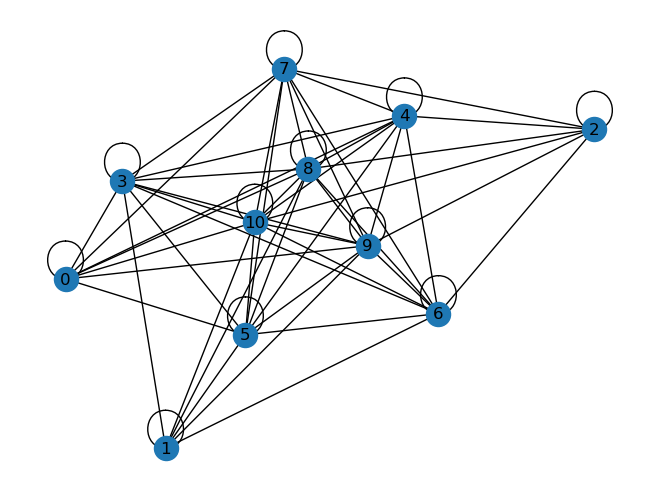

In [61]:
G = nx.from_numpy_array(Q)
nx.draw(G, with_labels=True)

Since the problem is relatively small, let's find best and worst solutions using enumeration

In [62]:
def evaluate_all_bitstrings(Q):
    """
    Evaluate QUBO objective x^T Q x for all possible bitstrings.
    
    Args:
        Q (np.ndarray): QUBO matrix (nxn)
        verbose (bool): Print all solutions if True
    
    Returns:
        best_x (np.array): Optimal bitstring
        best_val (float): Optimal objective value
        all_solutions (list): List of (bitstring, value) tuples
    """

    #TODO Start
    n = Q.shape[0]
    
    # Generate all possible bitstrings
    bitstrings = list(itertools.product([0, 1], repeat=n))
    
    # Evaluate each bitstring
    solutions = []
    best_val = float('inf')
    best_x = None
    worst_val = float('-inf')
    worst_x = None
    
    for bits in bitstrings:
        x = np.array(bits)
        val = float(x @ Q @ x) + Beta # x^T Q x + Beta (constraint penalty constant)
        solutions.append((bits, val))
        
        if val < best_val:
            best_val = val
            best_x = x.copy()

        if val > worst_val:
            worst_val = val
            worst_x = x.copy()
            
    
    # Sort solutions by objective value
    solutions.sort(key=lambda x: x[1])
    
    print("\nBest solution:")
    print(f"x* = {best_x}")
    print(f"Objective value = {best_val:.6f}")

    print("\nWorst solution:")
    print(f"x* = {worst_x}")
    print(f"Objective value = {worst_val:.6f}")

    #print("\nAll solutions:")
    #print(solutions)
    
    return best_x, best_val, worst_x, worst_val, solutions
    
best_x, best_val, worst_x, worst_val, all_solutions = evaluate_all_bitstrings(Q)
#TODO End


Best solution:
x* = [0 0 0 0 0 0 0 0 0 0 1]
Objective value = 5.000000

Worst solution:
x* = [1 1 1 1 1 1 1 1 1 1 1]
Objective value = 5855.000000


### QAOA

In this section, we will describe the Quantum Approximate Optimization Algorithm (QAOA). [Farhi et al.](https://arxiv.org/pdf/1411.4028) (2014) originally introduced QAOA to tackle optimization problems. QAOA has shown promise for solving various combinatorial optimization problems, particularly those that can be formulated as finding the ground state of an Ising Hamiltonian.

In essence, QAOA is a variational algorithm composed of a variational quantum circuit (a kernel dependent on a set of parameter values) and a classical optimizer. The goal of QAOA is to use the classical optimizer to identify parameter values that generate a quantum circuit whose expectation value for a given cost Hamiltonian is minimized. In our case, the cost Hamiltonian corresponds to our linear constrained binary optimization problem converted to QUBO form.

**QAOA Algorithm Overview:**

1. **Problem Encoding**: Convert the constrained optimization problem to a QUBO, then to an Ising Hamiltonian
2. **Quantum Circuit**: Use parameterized quantum circuits with alternating cost and mixer layers
3. **Classical Optimization**: Optimize the circuit parameters to minimize the expected energy
4. **Sampling**: Sample the optimized quantum state to obtain candidate solutions

The algorithm alternates between:
- **Quantum subroutines**: Using CUDA-Q primitives like `observe` to estimate expectation values and `sample` to get probability distributions
- **Classical optimization**: Using methods like L-BFGS-B to optimize the variational parameters γ (gamma) and β (beta)

For our linear constrained optimization problem, QAOA provides an approximate solution by concentrating probability mass on low-energy configurations that correspond to good feasible solutions.

The diagram below depicts the subroutines in QAOA.

![](https://github.com/NVIDIA/cuda-q-academic/blob/main/qaoa-for-max-cut/images/QAOA-flowchart.png?raw=true)

The two green process blocks in the image above represent the quantum subroutines that we'll execute with CUDA-Q primitives. The green process block on the left will use the `observe` primitive to estimate the expectation value (this primitive is subsumed in a `vqe` call) and the green process on the right will use the `sample` primitive to identify the most probable outcome of the circuit. We'll describe how to program this entire flowchart using CUDA-Q in the following sections.


### CUDA-Q Basics

Before implementing QAOA for our optimization problem, let's review the key CUDA-Q primitives we'll need. CUDA-Q uses the concept of "kernels" to represent quantum programs. While every quantum circuit is a kernel, kernels provide better interplatform compatibility and control flow for quantum computing tasks.

There are two main primitives essential for QAOA:
1. **`observe`** - Computing expectation values of Hamiltonians for a given quantum state
2. **`sample`** - Sampling from quantum circuits to approximate probability distributions

These primitives are fundamental to QAOA's hybrid quantum-classical approach:
- `observe` is used during parameter optimization to evaluate the cost function
- `sample` is used at the end to extract candidate solutions from the optimized quantum state

The examples below demonstrate these core CUDA-Q operations that we'll use in our QAOA implementation.

**Key CUDA-Q concepts for QAOA:**
- **Target selection**: We'll use CPU simulation (`qpp-cpu`) for this tutorial
- **Kernel definition**: Quantum circuits are defined using the `@cudaq.kernel` decorator
- **Parameter passing**: Kernels can accept parameters for variational algorithms like QAOA
- **Hamiltonian construction**: Using `spin` operators to build cost Hamiltonians

In simulation mode, the quantum state is built once and then sampled multiple times. This is perfect for QAOA where we need many samples to estimate expectation values and probability distributions accurately.  

In [63]:
# Example 1


##############################################################
#  1. Select a backend for kernel execution
cudaq.set_target("qpp-cpu")
##############################################################

##############################################################
# 2. Define a kernel function
@cudaq.kernel
def kernel(qubit_count: int):
    # Allocate our `qubit_count` to the kernel.
    qvector = cudaq.qvector(qubit_count)

    # Apply a Hadamard gate to the qubit indexed by 0.
    h(qvector[0])
    # Apply a Controlled-X gate between qubit 0 (acting as the control)
    # and each of the remaining qubits.
    for i in range(1, qubit_count):
        x.ctrl(qvector[0], qvector[i])

    # Measure the qubits
    # If we don't specify measurements, all qubits are measured in
    # the Z-basis by default.
    mz(qvector)

##############################################################
# 3. Call the kernel function with the variable qubit_count set to 2 and sample the outcomes
qubit_count = 2
result = cudaq.sample(kernel, qubit_count, shots_count=1000)

print(result)

{ 00:514 11:486 }



The next example shows how to use CUDA-Q to compute the expectation value $\langle \psi |H|\psi\rangle$, where $H$ is a Hamiltonian and $|\psi\rangle$ is a quantum state defined by the kernel. This demonstrates the `observe` primitive that we'll use extensively in QAOA for evaluating the cost function during parameter optimization.

The Hamiltonian $H = ZI + 2IY - XZ$ is encoded using the `spin` operators in `cudaq`. These operators can be combined using `+` and `*` to build complex Hamiltonians like our QUBO cost function. The `observe` primitive computes many statistics, but we will primarily need the `.expectation()` value for QAOA optimization.

This example shows how CUDA-Q handles:
- **Hamiltonian construction**: Building spin operators for quantum observables
- **Expectation value computation**: The core operation for QAOA cost evaluation
- **State preparation**: How quantum kernels prepare states for measurement

In [64]:
# Example 2

# Define a quantum kernel function.
@cudaq.kernel
def kernel(qubit_count: int):
    # Allocate our `qubit_count` to the kernel.
    qvector = cudaq.qvector(qubit_count)

    # Apply a Hadamard gate to the qubit indexed by 0.
    h(qvector[0])
    # Apply a Controlled-X gate between qubit 0 (acting as the control)
    # and each of the remaining qubits.
    for i in range(1, qubit_count):
        x.ctrl(qvector[0], qvector[i])


# Define a Hamiltonian in terms of Pauli Spin operators.
hamiltonian = spin.z(0) + 2*spin.y(1) - spin.x(0) * spin.z(1)

# Compute the expectation value given the state prepared by the kernel.
result = cudaq.observe(kernel, hamiltonian, qubit_count, shots_count = 1000).expectation()

print('<psi|H|psi> =', result)

<psi|H|psi> = -0.01400000000000004


## From QUBO to Spin Operator Hamiltonian

The QUBO is a useful format because it is well understood how to map a QUBO to a quantum Hamiltonian whose ground state corresponds to the QUBO solution.

The first step is to derive the Ising Hamiltonian, $H_C$, which corresponds to the QUBO problem. Starting with the QUBO definition $\sum_i Q_{ii} x_i + \sum_{i<j} Q_{ij} x_i  x_j$, substitute the binary variables with spin variables so $x_i = \frac{1-z_i}{2}$. This results in 

$$ \frac{1}{2} \sum_i Q_{ii} (1-z_i) +  \frac{1}{4} \sum_{i<j} Q_{ij} (1 - z_i - z_j +z_iz_j) $$
$$ \frac{1}{2} \sum_i Q_{ii} -\frac{1}{2} \sum_i Q_{ii}z_i +  \frac{1}{4} \sum_{i<j} Q_{ij}  - \frac{1}{4} \sum_{i<j} Q_{ij} z_i - \frac{1}{4} \sum_{i<j} Q_{ij}  z_j + \frac{1}{4} \sum_{i<j} Q_{ij}z_iz_j$$


Grouping the terms results in a constant $C$ that can be dropped as it has no impact on the optimization but we account for it also.

$$C=  \frac{1}{2} \sum_i Q_{ii} + \frac{1}{4} \sum_{i<j} Q_{ij}   $$

We can further simplify things by grouping the single variable terms and the interacting terms:
$$H_C =\sum_{i,j} J_{ij}\, z_i z_j + \sum_i h_i\, z_i,$$
 where $h_i$ are the coefficients of the single variable terms and $J_{ij}$ are the coefficients of the interacting terms: 

$$ h_i  = \frac{-1}{2}Q_{ii}  - \frac{1}{4}\sum_{i<j} Q_{ij} - \frac{1}{4}\sum_{k<i} Q_{ki} $$

$$ J_{ij}  =  \frac{1}{4}Q_{ij}. $$

In [65]:
from itertools import combinations

print(Q)

def qubo_to_ising(Q, tol=1e-12):
    """
    Convert a QUBO matrix to an Ising Hamiltonian
    
    Args:
        Q (np.ndarray): QUBO matrix (nxn)
        tol (float): Cutoff for near zero terms
    
    Returns:
        h_list (list): List of coefficients for single variable terms 
        pair_indices (list): Flattened list corresponding to the pairs of indices for off diagonal QUBO terms
        J_list (list): List of two variable term coefficients.
        constant (float): Constant term C from QUBO to Ising conversion
    """
    #TODO Start
    n = Q.shape[0]
    
    # two-body 
    J_pairs, J_coeffs = [], []
    for i, j in combinations(range(n), 2):
        coeff = 0.25 * Q[i, j]
        if abs(coeff) > tol:
            J_pairs.extend([i, j])       
            J_coeffs.append(float(coeff))
    
    # one-body
    h = np.zeros(n, dtype=float)

    # diagonal contributions
    for i in range(n):

        h[i] += -0.5 * Q[i,i]  #diagonal

        for j in range(n):     # linear z_i terms (sum terms in same row)

            if j > i:

                h[i] += -0.25 * Q[i,j]

        for k in range(i):    # linear z_j terms (sum terms in same column)


            if k < i:

                h[i] += -0.25 * Q[k,i]
    
    # Calculate the constant term C from QUBO to Ising conversion
    # C = (1/2) * sum(Q_ii) + (1/4) * sum(Q_ij for i<j)
    constant = 0.5 * np.sum(np.diag(Q))
    for i, j in combinations(range(n), 2):
        constant += 0.25 * Q[i, j]
    
    return h.tolist(), J_pairs, J_coeffs, constant

h_list, pair_inds, J_list, ising_constant =    qubo_to_ising(Q) 

print(h_list)
print(pair_inds)
print(J_list)
print(f"Ising constant C: {ising_constant}")

# Total constant term including Beta from constraint penalty
# Beta = rho * b^T * b (from constraint penalty)
# C = (1/2) * sum(Q_ii) + (1/4) * sum(Q_ij for i<j) (from QUBO to Ising conversion)
total_constant = Beta + ising_constant
print(f"Beta (constraint penalty): {Beta}")
print(f"Total constant (Beta + C): {total_constant}")

def ising_to_spinop(h, pair_inds, J, n_qubits, constant=0.0):
    """
    Creates a CUDA-Q SpinOperator Hamiltonian
    
    Args:
        h_list (list): List of coefficients for single variable terms 
        pair_indices (list): Flattened list corresponding to the pairs of indices for off diagonal QUBO terms
        J_list (list): List of two variable term coefficients.
        constant (float): Constant term to add to the Hamiltonian
    
    Returns:
        H (cudaq.spinop): SpinOperator QUBO Hamiltonian with constant term
    """
    H = cudaq.SpinOperator()
    
    # Add constant term (identity operator)
    if constant != 0.0:
        H += constant * spin.i(0)  # Identity on qubit 0 (affects entire system)
    
    # Add single qubit terms
    for i, coeff in enumerate(h):
        if coeff: H += coeff * spin.z(i)
    
    # Add two-qubit interaction terms
    for k, coeff in enumerate(J):
        i, j = pair_inds[2*k : 2*k+2]
        H += coeff * spin.z(i) * spin.z(j)
    return H

n_qubits = 11
H = ising_to_spinop(h_list, pair_inds, J_list, n_qubits, total_constant)
print(H)

# Note: The Hamiltonian H now includes the total constant term.
# For consistency across all energy calculations, we'll use total_constant as the offset.

[[ -46    0    0   48   48   48    0   48   48   48   48]
 [   0  -44    0   48    0   48   48    0   48   48   48]
 [   0    0  -44    0   48    0   48   48   48   48   48]
 [  48   48    0  -92   48   96   48   48   96   96   96]
 [  48    0   48   48  -92   48   48   96   96   96   96]
 [  48   48    0   96   48  -92   48   48   96   96   96]
 [   0   48   48   48   48   48  -91   48   96   96   96]
 [  48    0   48   48   96   48   48  -92   96   96   96]
 [  48   48   48   96   96   96   96   96 -139  144  144]
 [  48   48   48   96   96   96   96   96  144 -138  144]
 [  48   48   48   96   96   96   96   96  144  144 -139]]
[-61.0, -50.0, -50.0, -110.0, -110.0, -110.0, -98.5, -110.0, -158.5, -159.0, -158.5]
[0, 3, 0, 4, 0, 5, 0, 7, 0, 8, 0, 9, 0, 10, 1, 3, 1, 5, 1, 6, 1, 8, 1, 9, 1, 10, 2, 4, 2, 6, 2, 7, 2, 8, 2, 9, 2, 10, 3, 4, 3, 5, 3, 6, 3, 7, 3, 8, 3, 9, 3, 10, 4, 5, 4, 6, 4, 7, 4, 8, 4, 9, 4, 10, 5, 6, 5, 7, 5, 8, 5, 9, 5, 10, 6, 7, 6, 8, 6, 9, 6, 10, 7, 8, 7, 9, 7, 10, 8, 


### QAOA Circuit

In order to program QAOA, we need to understand the structure of the variational QAOA quantum circuit. The general structure of the circuit for our linear constrained optimization problem is:

**Circuit Structure:**
* **Initialization**: Each binary variable corresponds to one qubit, initialized in superposition using Hadamard gates
* **Layered Structure**: The circuit consists of repeated blocks (layers) of problem and mixer operations
* **Problem Layer**: Implements the cost Hamiltonian derived from our QUBO matrix using:
  - Single-qubit Z rotations for linear terms (h_i coefficients)
  - Two-qubit ZZ interactions for quadratic terms (J_ij coefficients)
* **Mixer Layer**: Applies X rotations to all qubits to enable transitions between computational basis states

**Key Components:**
1. **Problem Hamiltonian**: Encodes our constrained optimization objective
   - RZ gates for single variable terms: `rz(2*γ*h_i, qubit_i)`
   - CNOT-RZ-CNOT for variable interactions: implements `e^{-iγ*J_ij*Z_i*Z_j}`

2. **Mixer Hamiltonian**: Provides quantum superposition and transitions
   - RX gates on all qubits: `rx(2*β, qubit_i)`

3. **Variational Parameters**:
   - **γ (gamma)**: Controls the problem Hamiltonian strength
   - **β (beta)**: Controls the mixer strength
   - Each layer has its own γ and β parameters

The number of layers determines the circuit depth and approximation quality. More layers generally provide better solutions but require more parameters to optimize.

![](https://github.com/NVIDIA/cuda-q-academic/blob/main/qaoa-for-max-cut/images/qaoa-circuit-layers.png?raw=true)

In [66]:
@cudaq.kernel
def qaoa_kernel(theta : list[float],
                qubit_count : int,
                layers : int,
                h_coeffs : list[float],
                pair_inds : list[int],
                J_coeffs : list[float]):

    """
    Creates a CUDA-Q kernel corresponding to a QAOA circuit
    
    Args:
        theta (list): list of the variational parameters
        qubit_count (int): number of qubits
        layers (int): number of qaoa layers
        h_list (list): List of coefficients for single variable terms 
        pair_indices (list): Flattened list corresponding to the pairs of indices for off diagonal QUBO terms
        J_list (list): List of two variable term coefficients.
    
    Returns:
        (cudaq.kernel): QAOA kernel
    """

    #TODO Start
    q = cudaq.qvector(qubit_count)

    # Hadamards
    for idx in range(qubit_count):
        h(q[idx])

    for layer in range(layers):
        gamma = theta[layer]
        beta  = theta[layer + layers]

        # cost e^{-i γ H_C}
        # single-Z
        for i in range(qubit_count):
            coeff = h_coeffs[i]
            if coeff != 0.0:
                rz(2.0 * gamma * coeff, q[i])

        # ZZ
        num_pairs = len(J_coeffs)          # compile-time constant
        for k in range(num_pairs):
            i = pair_inds[2 * k]
            j = pair_inds[2 * k + 1]
            coeff = J_coeffs[k]

            cx(q[i], q[j])
            rz(2.0 * gamma * coeff, q[j])
            cx(q[i], q[j])

        # mixer e^{-i β ∑ X}
        for i in range(qubit_count):
            rx(2.0 * beta, q[i])
     #TODO END

Let's test the QAOA kernel by using classical optimization to find the best parameters. The code below:
1. Computes expectation values from the quantum circuit for different parameter values
2. Uses classical optimization (L-BFGS-B) to optimize the γ (gamma) and β (beta) parameters
3. Samples the optimized circuit to get probability distributions over bit-strings
4. Analyzes whether the optimal solution appears with high probability  

/tmp/ipykernel_12748/580379606.py:29: DeprecationWarning: scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.
  opt_result = minimize(qaoa_cost, init, method='L-BFGS-B',


  message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 47.27886292388971
        x: [ 4.846e+00  1.432e+00  3.791e+00  3.002e+00 -1.172e+00
            -1.361e+00]
      nit: 95
      jac: [ 4.595e-01  2.223e-01  8.310e-02 -4.555e-03  1.444e-03
            -1.066e-05]
     nfev: 938
     njev: 134
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>

Optimization Results:
Minimum Ising expectation value: 47.278863
Corresponding QUBO energy: -288.221137
Most-probable bit-string: 00000010001
QUBO energy of most-probable solution: 106.000000


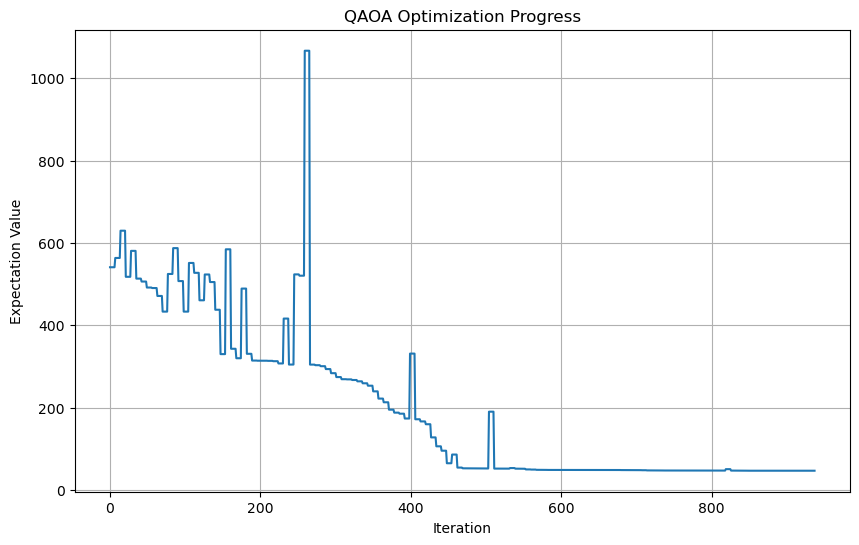

In [ ]:
# Note: This cell may take approximately 5 minutes or more to run in Colab. Please be patient.

import matplotlib.pyplot as plt
from scipy.optimize import minimize

n_qubits = 11

layers = 3
init = np.random.uniform(-np.pi, np.pi, 2*layers)

initial= cudaq.sample(qaoa_kernel, init, n_qubits, layers,  # Sample results from initial state with all 0 parameters
                     h_list, pair_inds, J_list, shots_count=10000)

#print(initial)


cost_history = []

def qaoa_cost(theta):
    res = cudaq.observe(qaoa_kernel, H, theta, n_qubits, layers,
                        h_list, pair_inds, J_list)
    cost = res.expectation()
    cost_history.append(cost)
    
    # Note: The expectation value includes the total_constant from the Hamiltonian
    # This represents the expected value of the Ising Hamiltonian
    return cost

opt_result = minimize(qaoa_cost, init, method='L-BFGS-B',
                      options={'maxiter': 500, 'disp': True})


print(opt_result)

# The optimization result contains the minimum Ising Hamiltonian expectation value
ising_min_expectation = opt_result.fun
corresponding_qubo_energy = ising_min_expectation - ising_constant
print(f"\nOptimization Results:")
print(f"Minimum Ising expectation value: {ising_min_expectation:.6f}")
print(f"Corresponding QUBO energy: {corresponding_qubo_energy:.6f}")

shots = cudaq.sample(qaoa_kernel, opt_result.x, n_qubits, layers,
                     h_list, pair_inds, J_list, shots_count=10000)

#print(shots)
most_probable_bitstring = np.array(shots.most_probable()).astype(str)
print(f'Most-probable bit-string: {most_probable_bitstring}')

# Calculate the actual QUBO energy for the most probable bitstring
most_probable_bits = np.array([int(b) for b in shots.most_probable()])
actual_qubo_energy = float(most_probable_bits @ Q @ most_probable_bits) + Beta
print(f'QUBO energy of most-probable solution: {actual_qubo_energy:.6f}')

plt.figure(figsize=(10, 6))
plt.plot(cost_history)
plt.xlabel('Iteration')
plt.ylabel("Expectation Value")
plt.title('QAOA Optimization Progress')
plt.grid(True)
plt.show()

The QAOA result may not always produce the global optimum most frequently due to the *approximate* nature of QAOA. However, the resulting QAOA state should sample good solutions (including the optimal one) with much higher probability than randomly sampling all bitstrings. Let's compare the probability distributions to verify this quantum advantage.

## Analysis: QAOA vs Random Sampling

Let's analyze and compare the QAOA results with random sampling. We'll create bar plots showing the probability distributions over energy levels for both approaches.


In [82]:
def compute_qaoa_energy_distribution(shots, Q, constant_offset=0.0):
    """
    Compute energy distribution from QAOA shots
    
    Args:
        shots: CUDA-Q sampling results
        Q: QUBO matrix
        constant_offset: constant term to add to energy calculation
    
    Returns:
        energy_counts: dictionary mapping energy -> probability
    """
    # Extract bitstrings and their counts
    total_shots = sum(shots.values())
    energy_counts = {}
    
    for bitstring, count in shots.items():
        # Convert bitstring to numpy array
        x = np.array([int(b) for b in bitstring])
        # Compute energy: x^T Q x + constant_offset
        energy = float(x @ Q @ x) + constant_offset
        
        if energy in energy_counts:
            energy_counts[energy] += count
        else:
            energy_counts[energy] = count
    
    # Convert counts to probabilities
    for energy in energy_counts:
        energy_counts[energy] /= total_shots
    
    return energy_counts

def compute_random_energy_distribution(all_solutions):
    """
    Compute energy distribution for random (uniform) sampling
    
    Args:
        all_solutions: list of (bitstring, energy) tuples from enumeration
    
    Returns:
        energy_counts: dictionary mapping energy -> probability
    """
    total_solutions = len(all_solutions)
    energy_counts = {}
    
    for bitstring, energy in all_solutions:
        if energy in energy_counts:
            energy_counts[energy] += 1
        else:
            energy_counts[energy] = 1
    
    # Convert counts to probabilities (uniform distribution)
    for energy in energy_counts:
        energy_counts[energy] /= total_solutions
    
    return energy_counts

# Compute energy distributions
# Note: For consistency, both should use the same energy calculation method
# The evaluate_all_bitstrings function calculates: x^T Q x + Beta
# So we'll use Beta as the constant offset for both
qaoa_energy_dist = compute_qaoa_energy_distribution(shots, Q, Beta)
random_energy_dist = compute_random_energy_distribution(all_solutions)

print("QAOA Energy Distribution (top 10):")
qaoa_sorted = sorted(qaoa_energy_dist.items())[:10]
for energy, prob in qaoa_sorted:
    print(f"Energy: {energy:.1f}, Probability: {prob:.4f}")

print("\nRandom Energy Distribution (top 10):")
random_sorted = sorted(random_energy_dist.items())[:10]
for energy, prob in random_sorted:
    print(f"Energy: {energy:.1f}, Probability: {prob:.4f}")


QAOA Energy Distribution (top 10):
Energy: 5.0, Probability: 0.0885
Energy: 6.0, Probability: 0.0184
Energy: 7.0, Probability: 0.0299
Energy: 8.0, Probability: 0.0061
Energy: 10.0, Probability: 0.0012
Energy: 52.0, Probability: 0.0235
Energy: 53.0, Probability: 0.0420
Energy: 54.0, Probability: 0.0082
Energy: 55.0, Probability: 0.0445
Energy: 56.0, Probability: 0.0128

Random Energy Distribution (top 10):
Energy: 5.0, Probability: 0.0010
Energy: 6.0, Probability: 0.0005
Energy: 7.0, Probability: 0.0005
Energy: 8.0, Probability: 0.0020
Energy: 10.0, Probability: 0.0005
Energy: 52.0, Probability: 0.0020
Energy: 53.0, Probability: 0.0005
Energy: 54.0, Probability: 0.0010
Energy: 55.0, Probability: 0.0010
Energy: 56.0, Probability: 0.0029


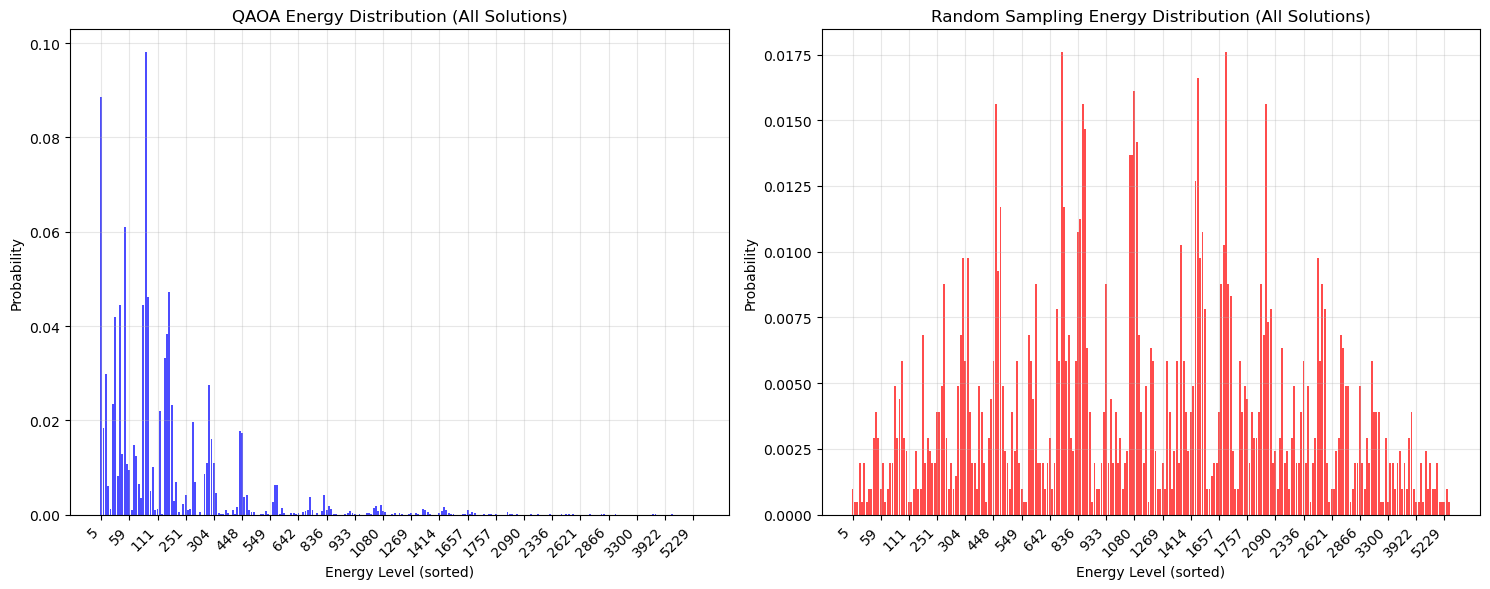

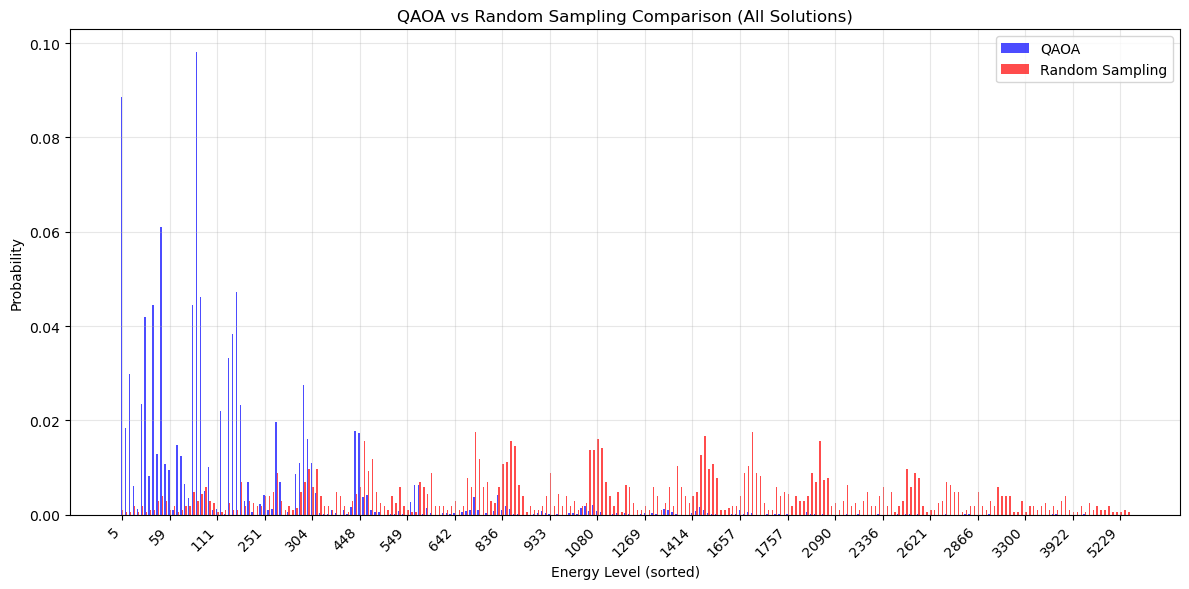

In [83]:
def plot_energy_comparison(qaoa_dist, random_dist, title_suffix=""):
    """
    Create bar plots comparing QAOA and random sampling energy distributions
    
    Args:
        qaoa_dist: dictionary mapping energy -> probability for QAOA
        random_dist: dictionary mapping energy -> probability for random
        title_suffix: additional text for plot titles
    """
    # Get all unique energies and sort them
    all_energies = sorted(set(list(qaoa_dist.keys()) + list(random_dist.keys())))
    
    # Prepare data for plotting
    qaoa_probs = [qaoa_dist.get(energy, 0) for energy in all_energies]
    random_probs = [random_dist.get(energy, 0) for energy in all_energies]
    
    # Create side-by-side bar plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # QAOA results
    bars1 = ax1.bar(range(len(all_energies)), qaoa_probs, alpha=0.7, color='blue')
    ax1.set_xlabel('Energy Level (sorted)')
    ax1.set_ylabel('Probability')
    ax1.set_title(f'QAOA Energy Distribution{title_suffix}')
    ax1.grid(True, alpha=0.3)
    
    # Add energy values as x-tick labels (show every nth label to avoid crowding)
    step = max(1, len(all_energies) // 20)  # Show at most 20 labels
    ax1.set_xticks(range(0, len(all_energies), step))
    ax1.set_xticklabels([f'{all_energies[i]:.0f}' for i in range(0, len(all_energies), step)], 
                        rotation=45, ha='right')
    
    # Random sampling results
    bars2 = ax2.bar(range(len(all_energies)), random_probs, alpha=0.7, color='red')
    ax2.set_xlabel('Energy Level (sorted)')
    ax2.set_ylabel('Probability')
    ax2.set_title(f'Random Sampling Energy Distribution{title_suffix}')
    ax2.grid(True, alpha=0.3)
    
    # Add energy values as x-tick labels
    ax2.set_xticks(range(0, len(all_energies), step))
    ax2.set_xticklabels([f'{all_energies[i]:.0f}' for i in range(0, len(all_energies), step)], 
                        rotation=45, ha='right')
    
    plt.tight_layout()
    plt.show()
    
    # Also create an overlay comparison plot
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
    
    x_positions = np.arange(len(all_energies))
    width = 0.35  # Width of bars
    
    bars1 = ax.bar(x_positions - width/2, qaoa_probs, width, alpha=0.7, 
                   color='blue', label='QAOA')
    bars2 = ax.bar(x_positions + width/2, random_probs, width, alpha=0.7, 
                   color='red', label='Random Sampling')
    
    ax.set_xlabel('Energy Level (sorted)')
    ax.set_ylabel('Probability')
    ax.set_title(f'QAOA vs Random Sampling Comparison{title_suffix}')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Add energy values as x-tick labels
    ax.set_xticks(range(0, len(all_energies), step))
    ax.set_xticklabels([f'{all_energies[i]:.0f}' for i in range(0, len(all_energies), step)], 
                       rotation=45, ha='right')
    
    plt.tight_layout()
    plt.show()
    
    return all_energies, qaoa_probs, random_probs

# Create the comparison plots
energies, qaoa_probs, random_probs = plot_energy_comparison(
    qaoa_energy_dist, random_energy_dist, " (All Solutions)")


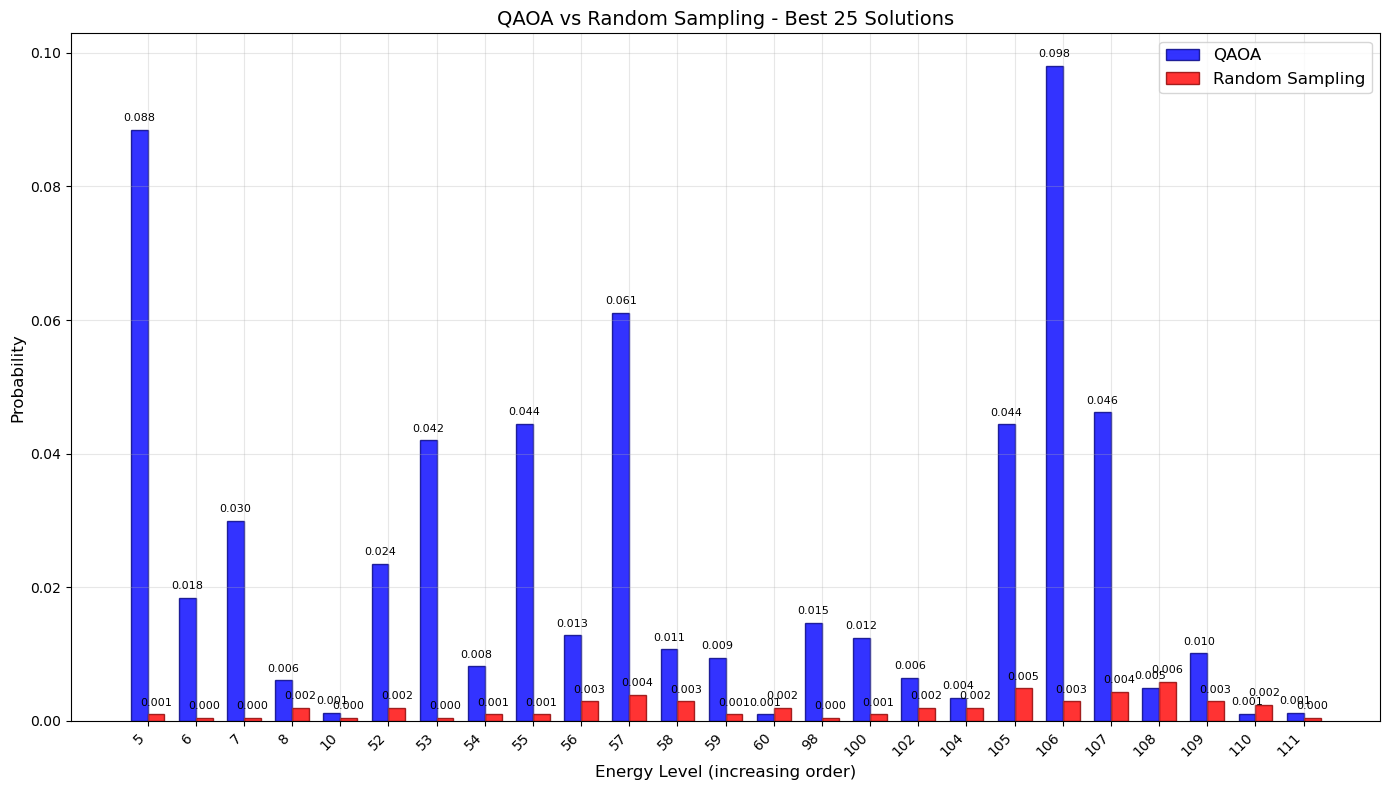


Summary for best 25 solutions:
Optimal energy: 5.0
QAOA probability of optimal: 0.0885
Random probability of optimal: 0.0010

Cumulative probability for best 25 solutions:
QAOA: 0.6004
Random: 0.0508
QAOA advantage: 11.82x better


In [84]:
# Focus on the best solutions to highlight QAOA advantage
def plot_best_solutions_comparison(qaoa_dist, random_dist, top_n=20):
    """
    Create focused plots showing only the best (lowest energy) solutions
    
    Args:
        qaoa_dist: QAOA energy distribution
        random_dist: Random sampling energy distribution  
        top_n: number of best solutions to show
    """
    # Get the top_n best energies (lowest values)
    all_energies = sorted(set(list(qaoa_dist.keys()) + list(random_dist.keys())))
    best_energies = all_energies[:top_n]
    
    qaoa_best_probs = [qaoa_dist.get(energy, 0) for energy in best_energies]
    random_best_probs = [random_dist.get(energy, 0) for energy in best_energies]
    
    # Create comparison plot for best solutions
    fig, ax = plt.subplots(1, 1, figsize=(14, 8))
    
    x_positions = np.arange(len(best_energies))
    width = 0.35
    
    bars1 = ax.bar(x_positions - width/2, qaoa_best_probs, width, 
                   alpha=0.8, color='blue', label='QAOA', edgecolor='navy')
    bars2 = ax.bar(x_positions + width/2, random_best_probs, width, 
                   alpha=0.8, color='red', label='Random Sampling', edgecolor='darkred')
    
    # Add value labels on bars
    for i, (bar1, bar2) in enumerate(zip(bars1, bars2)):
        if qaoa_best_probs[i] > 0:
            ax.text(bar1.get_x() + bar1.get_width()/2, bar1.get_height() + 0.001,
                   f'{qaoa_best_probs[i]:.3f}', ha='center', va='bottom', fontsize=8)
        if random_best_probs[i] > 0:
            ax.text(bar2.get_x() + bar2.get_width()/2, bar2.get_height() + 0.001,
                   f'{random_best_probs[i]:.3f}', ha='center', va='bottom', fontsize=8)
    
    ax.set_xlabel('Energy Level (increasing order)', fontsize=12)
    ax.set_ylabel('Probability', fontsize=12)
    ax.set_title(f'QAOA vs Random Sampling - Best {top_n} Solutions', fontsize=14)
    ax.legend(fontsize=12)
    ax.grid(True, alpha=0.3)
    
    # Set x-tick labels to actual energy values
    ax.set_xticks(x_positions)
    ax.set_xticklabels([f'{energy:.0f}' for energy in best_energies], 
                       rotation=45, ha='right')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print(f"\nSummary for best {top_n} solutions:")
    print(f"Optimal energy: {best_energies[0]:.1f}")
    print(f"QAOA probability of optimal: {qaoa_dist.get(best_energies[0], 0):.4f}")
    print(f"Random probability of optimal: {random_dist.get(best_energies[0], 0):.4f}")
    
    # Calculate cumulative probability for top solutions
    qaoa_cumulative = sum(qaoa_dist.get(energy, 0) for energy in best_energies)
    random_cumulative = sum(random_dist.get(energy, 0) for energy in best_energies)
    
    print(f"\nCumulative probability for best {top_n} solutions:")
    print(f"QAOA: {qaoa_cumulative:.4f}")
    print(f"Random: {random_cumulative:.4f}")
    print(f"QAOA advantage: {qaoa_cumulative/random_cumulative:.2f}x better")

plot_best_solutions_comparison(qaoa_energy_dist, random_energy_dist, top_n=25)


## Analysis Summary

The visualizations above demonstrate the key advantage of QAOA over random sampling:

### Key Observations:

1. **Concentration on Good Solutions**: QAOA concentrates probability mass on lower-energy (better) solutions, while random sampling distributes probability uniformly across all possible solutions.

2. **Quantum Advantage**: QAOA finds better approximate solutions more frequently than would be expected from random sampling, even though it may not always find the global optimum.

3. **Energy Distribution Shape**: 
   - QAOA shows a peaked distribution focused on lower energies
   - Random sampling shows uniform probability across all energy levels

4. **Practical Impact**: For optimization problems, QAOA provides a significant advantage by making good solutions much more likely to be sampled.




